31
30


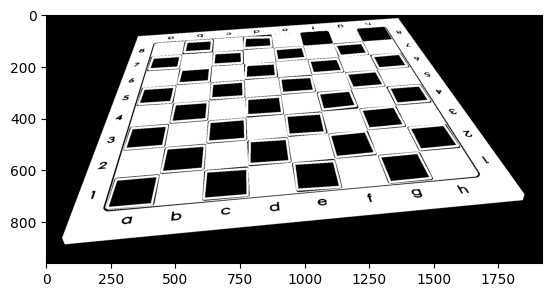

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

original_image = cv2.imread('origin.png')

rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)


gaussian_blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
ret,otsu_binary = cv2.threshold(gaussian_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


canny = cv2.Canny(otsu_binary,20,255)

kernel = np.ones((7, 7), np.uint8)

img_dilation = cv2.dilate(canny, kernel, iterations=1)

lines = cv2.HoughLinesP(img_dilation, 1, np.pi/180, threshold=200, minLineLength=100, maxLineGap=50)

if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]

        # draw lines
        cv2.line(img_dilation, (x1, y1), (x2, y2), (100,100,255), 2)

kernel = np.ones((3, 3), np.uint8)

img_dilation_2 = cv2.dilate(img_dilation, kernel, iterations=1)

plt.imshow(img_dilation_2,cmap="gray")

board_contours, hierarchy = cv2.findContours(img_dilation_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

square_centers=list()

# draw filtered rectangles to "canny" image for better visualization
board_squared = canny.copy()

black_count = 0
white_count = 0

for contour in board_contours:
    if 4000 < cv2.contourArea(contour) < 40000:
        # Approximate the contour to a simpler shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Ensure the approximated contour has 4 points (quadrilateral)
        if len(approx) == 4:
            pts = [pt[0] for pt in approx]  # Extract coordinates

            # Define the points explicitly
            pt1 = tuple(pts[0])
            pt2 = tuple(pts[1])
            pt4 = tuple(pts[2])
            pt3 = tuple(pts[3])

            x, y, w, h = cv2.boundingRect(contour)
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            square_centers.append([center_x,center_y,pt2,pt1,pt3,pt4])



            # Draw the lines between the points
            cv2.line(otsu_binary, pt1, pt2, (255, 255, 0), 7)
            cv2.line(otsu_binary, pt1, pt3, (255, 255, 0), 7)
            cv2.line(otsu_binary, pt2, pt4, (255, 255, 0), 7)
            cv2.line(otsu_binary, pt3, pt4, (255, 255, 0), 7)

sorted_coordinates = sorted(square_centers, key=lambda x: x[1], reverse=True)

groups = []
current_group = [sorted_coordinates[0]]

for coord in sorted_coordinates[1:]:
    if abs(coord[1] - current_group[-1][1]) < 50:
        current_group.append(coord)
    else:
        groups.append(current_group)
        current_group = [coord]

# Append the last group
groups.append(current_group)

# Step 2: Sort each group by the second index (column values)
for group in groups:
    group.sort(key=lambda x: x[0])

# Step 3: Combine the groups back together
sorted_coordinates = [coord for group in groups for coord in group]

sorted_coordinates[:10]

# It is the additional operation for undetected square.
for num in range(len(sorted_coordinates)-1):
    if abs(sorted_coordinates[num][1] - sorted_coordinates[num+1][1])< 100 :
        if sorted_coordinates[num+1][0] - sorted_coordinates[num][0] > 200:
            x=(sorted_coordinates[num+1][0] + sorted_coordinates[num][0])/2
            y=(sorted_coordinates[num+1][1] + sorted_coordinates[num][1])/2
            p1=sorted_coordinates[num][5]
            p2=sorted_coordinates[num+1][4]
            p3=sorted_coordinates[num+1][3]
            p4=sorted_coordinates[num][2]
            cv2.line(otsu_binary, p1, p2, (255, 255, 0), 7)
            cv2.line(otsu_binary, p1, p4, (255, 255, 0), 7)
            cv2.line(otsu_binary, p2, p3, (255, 255, 0), 7)
            cv2.line(otsu_binary, p3, p4, (255, 255, 0), 7)
            sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])

# This step is count the number of black square and white square.
for coordinate in sorted_coordinates:
    points = coordinate[2:]  # Get only the tuple points

    # Extract x and y coordinates from the points
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    # Determine the bounding box of the rectangle
    x_min = int(min(x_coords))
    x_max = int(max(x_coords))
    y_min = int(min(y_coords))
    y_max = int(max(y_coords))

    # Extract the rectangle from the binary image
    rectangle = otsu_binary[y_min:y_max, x_min:x_max]

    # Calculate the average color of the rectangle
    avg_color = np.mean(rectangle)

    # Count based on average color
    if avg_color > 127:  # Assuming average color > 127 is white
        white_count += 1
    else:
        black_count += 1

print(white_count)
print(black_count)

plt.imshow(otsu_binary,cmap="gray")


